# ComputeFramework

**One big idea: break up large data into pieces, run computations on the pieces without filling up memory**

Low-level view:

ComputeFramework *reorganizes* your computation so that it can be:
  - out-of-core
  - parallel
  
  
High-level view:

- Array library
- Other data-parallel libraries

## Out-of-core
Out-of-core computation means working with data which does not fit in the RAM. Let's find out how much RAM we have left. `Sys.free_memory()` can tell you this.

In [1]:
Int(Sys.free_memory())/10^9

123.205656576

In [ ]:
rand(5*10^8) # Docker kills my Julia because I allocated too much

In [2]:
io = open("/scratch/mybigarray", "w+")
X = Mmap.mmap(io, Vector{Float64}, (5*10^8,))
close(io)

In [3]:
@time rand!(X)

  5.446527 seconds (27.67 k allocations: 1.211 MB, 0.07% gc time)


500000000-element Array{Float64,1}:
 0.699571 
 0.831891 
 0.508932 
 0.707173 
 0.7831   
 0.444995 
 0.777119 
 0.674943 
 0.157073 
 0.441637 
 0.666546 
 0.656926 
 0.338891 
 ⋮        
 0.603209 
 0.556922 
 0.786834 
 0.235923 
 0.856844 
 0.357216 
 0.0710475
 0.401356 
 0.785052 
 0.347791 
 0.57127  
 0.682185 

Let's try to do something with it.

In [4]:
@time sum(X)

  8.432462 seconds (24.76 k allocations: 1.053 MB)


2.4999423858350474e8

But `mmap` quickly stops working...

In [ ]:
sum(sin(X).^2 + cos(X).^2)

# results in 8 GB allocation at any given time.

### Working with big arrays in ComputeFramework

In [1]:
#Pkg.clone("git://github.com/shashi/ComputeFramework.jl.git")
using ComputeFramework

In [4]:
x_node = rand(BlockPartition(5*10^7), 5*10^8);

We have not actually created the array `x_node` yet. `x_node` represents a *contract* to create the array.

We can create the array and write it directly to disk using `compute(save(x_node, "/scratch/X"))`. Again, you can think of `save` as returning a *contract* to save its input.

`compute` is the ComputeFramework primitive that actually realizes a contract.

In [8]:
@time X = compute(save(x_node, "/scratch/X"))

 13.802681 seconds (5.75 k allocations: 3.726 GB, 2.04% gc time)


ComputeFramework.Computed(500000000 Array{Float64,1} in 10 parts)

In [9]:
X = load(Context(), "/scratch/X")

ComputeFramework.Computed(500000000 Array{Float64,1} in 10 parts)

In [11]:
result = sum(sin(X).^2 + cos(X).^2);

In [12]:
@time compute(result)

 47.491239 seconds (705.96 k allocations: 26.109 GB, 1.82% gc time)


5.0e8

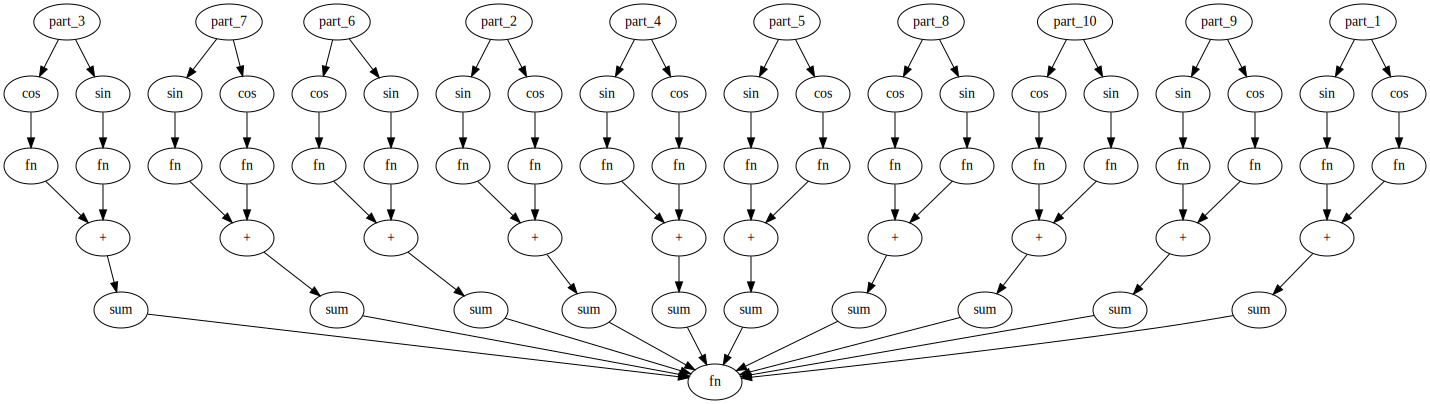

In [14]:
using GraphViz
Graph(show_plan(sum(sin(X).^2 + cos(X).^2)))

In [15]:
X = rand(BlockPartition(100, 100), 300, 200)
y = rand(BlockPartition(100), 300)

ComputeFramework.AllocateArray(Float64,rand,ComputeFramework.DenseDomain{1}((1:300,)),ComputeFramework.BlockPartition{1}((100,)))

In [16]:
using Colors

In [20]:
red = RGB(1,0,0)
blue = RGB(0,0,1)
white = RGB(1,1,1)

X_blocks = RGB[red for j=1:3, i=1:2]

In [21]:
X_blocks'

In [22]:
Y_blocks = hcat(RGB[blue for i=1:3], RGB[white for i=1:3])

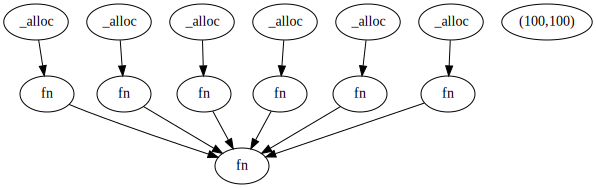

In [26]:
Graph(show_plan(X'))